In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
import copy
import subprocess
import rasterio
from rasterio.plot import show
import geopandas as gpd
from rasterio import mask
from inpaint_nans import inpaint_nans

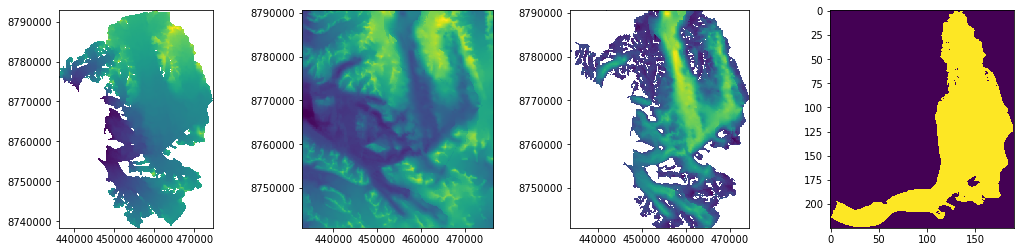

In [2]:
### data from lindbäck et al. (2018)
surf_o = rasterio.open("TIGRIF_DEM_ice_surface_150m_v1.tif") #from 2014
thk_o = rasterio.open("TIGRIF_DEM_ice_thickness_150m_1.tif") #from 2014, 2015, 2016 and some from 2000s
bed_o = rasterio.open("TIGRIF_DEM_subglacial_elevation_150m_v1.tif")

surf = surf_o.read(1)
thk = thk_o.read(1)
bed = bed_o.read(1)

### rgi outline
outline = gpd.read_file('./rgi_outlines/07_rgi60_Svalbard.shp')
outline = outline.to_crs(bed_o.crs)
outline = outline.loc[outline['RGIId'] == 'RGI60-07.01464', 'geometry']

bed_mask, bed_mask_meta = rasterio.mask.mask(bed_o, outline, crop=True)
surf_mask, surf_mask_meta = rasterio.mask.mask(surf_o, outline, crop=True)
thk_mask, thk_mask_meta = rasterio.mask.mask(thk_o, outline, crop=True)
mask_rgi = np.ones_like(bed_mask[0])
mask_rgi[bed_mask[0]>1e37]=0

fig, ax = plt.subplots(1,4, figsize=(18,4))
field1 = show(surf_o, ax = ax[0])
field2 = show(bed_o, ax = ax[1])
field3 = show(thk_o, ax = ax[2])
#outline.plot(ax=ax[2])
field4 = show(mask_rgi)

In [3]:
#### data from Jack ###
import scipy.io
mat_DEM_Vel = scipy.io.loadmat('HDF_2021_10_06.mat')
x_50m, y_50m = np.meshgrid(mat_DEM_Vel['HDF'][0,0][0], mat_DEM_Vel['HDF'][0,0][1])

Z_50m_90 = mat_DEM_Vel['HDF'][0,0][2]
Z_50m_09 = mat_DEM_Vel['HDF'][0,0][3]
Z_50m_14 = mat_DEM_Vel['HDF'][0,0][4]
Z_50m_20 = mat_DEM_Vel['HDF'][0,0][5]
Z_50m_20[0,:] = np.nan
Z_50m_20[:,-1] = np.nan

R2_50m_Vx = mat_DEM_Vel['HDF'][0,0][6]
R2_50m_Vx[np.isnan(R2_50m_Vx)] = 0
R2_50m_Vy = mat_DEM_Vel['HDF'][0,0][7]
R2_50m_Vy[np.isnan(R2_50m_Vy)] = 0
R2_50m_Vel = mat_DEM_Vel['HDF'][0,0][8]
R2_50m_Vel[np.isnan(R2_50m_Vel)] = 0

mat_RADAR = scipy.io.loadmat('HDF_radar_data.mat')
x_rad = mat_RADAR['HDF_radar_data'][0,0][0]
y_rad = mat_RADAR['HDF_radar_data'][0,0][1]
xy_rad = np.stack([x_rad, y_rad], axis=1)[:,:,0]
rad = mat_RADAR['HDF_radar_data'][0,0][2]

In [4]:
### official 50 m NPI DEM ###
NPI_DEM_o = rasterio.open("./S0_DTM50.tif")
window = (NPI_DEM_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1))
NPI_50m_DEM = np.zeros_like(Z_50m_20)
NPI_50m_DEM[1:,1:] = np.flip(NPI_DEM_o.read(1, window = window), axis=0)  ## NPI_DEM is not correctly oriented when imported (no idea why), therefore it needs to be flipped

In [5]:
### masks ###
mask_50m = -1*np.logical_or(np.isnan(Z_50m_14), np.isnan(Z_50m_09))+1

retreat_50m_mask = np.logical_and(np.logical_and(-1*np.isnan(Z_50m_09)+1, mask_50m == 0), NPI_50m_DEM < 100)

mask_50m *= (-1*retreat_50m_mask+1)

ocean_50m_mask = (NPI_50m_DEM == 0)

In [6]:
### fill nan values ###
Z_50m_09[mask_50m==0]=NPI_50m_DEM[mask_50m==0]
Z_50m_09[np.isnan(Z_50m_09)] = NPI_50m_DEM[np.isnan(Z_50m_09)]
Z_50m_09[retreat_50m_mask == 1] = 0

Z_50m_14[mask_50m==0]=NPI_50m_DEM[mask_50m==0]
Z_50m_14[retreat_50m_mask == 1] = 0
Z_50m_14[np.isnan(Z_50m_14)] = NPI_50m_DEM[np.isnan(Z_50m_14)]

#Z_50m_20[mask_50m==0]=NPI_50m_DEM[mask_50m==0]
#Z_50m_20[np.isnan(Z_50m_20)] = NPI_50m_DEM[np.isnan(Z_50m_20)]

Z_50m_mean = (Z_50m_09+Z_50m_14)/2
Z_50m_mean[mask_50m==0] = NPI_50m_DEM[mask_50m==0]
Z_50m_mean[retreat_50m_mask] = -200

### calculate dhdt ###
dhdt_50m_0914 = (Z_50m_14 - Z_50m_09)/5
dhdt_50m_0914[np.isnan(dhdt_50m_0914)] = 0
#dhdt_50m_0914 = np.minimum(dhdt_50m_0914, np.median(dhdt_50m_0914[mask_50m==1]) + 5 * np.std(dhdt_50m_0914[mask_50m==1]))
#dhdt_50m_0914 = np.maximum(dhdt_50m_0914, np.median(dhdt_50m_0914[mask_50m==1]) - 5 * np.std(dhdt_50m_0914[mask_50m==1]))

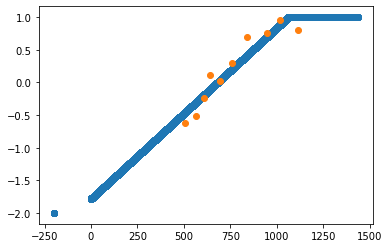

In [7]:
### mass balance from Jack in cm.w.eq. ###
import pandas as pd

smb_xyz_df = pd.read_excel ('HDF_mass_balance.xlsx', 0, header=None)
smb_net_df = pd.read_excel ('HDF_mass_balance.xlsx', 3, header=None)

smb_x = np.array(smb_xyz_df.loc[:,1])
smb_y = np.array(smb_xyz_df.loc[:,2])
smb_z = np.array(smb_xyz_df.loc[:,3])

smb_net_0914 = np.array(smb_net_df.loc[1:,7:12])/100*(10/9)   #convert to m.ice.eq.
smb_net_0914 = np.nanmean(smb_net_0914, axis=1)

### interpolate smb with elevation ###
from scipy import optimize

#def piecewise_linear(x):
#    return np.piecewise(x, [x < 0, x>=0], [lambda x: -x, lambda x: x])

#p , e = optimize.curve_fit(piecewise_linear, smb_z, smb_net_1421)
#test = piecewise_linear(Z_14, *p)

poly = np.poly1d(np.polyfit(smb_z,smb_net_0914,1))
smb_50m_fit = poly(Z_50m_mean)
smb_50m_fit[smb_50m_fit<-2] = -2
smb_50m_fit[smb_50m_fit>1] = 1


plt.scatter(Z_50m_mean, smb_50m_fit)
plt.scatter(smb_z, smb_net_0914)

In [8]:
### velocity from Jack ###
vel_xyz_df = pd.read_excel('HDF_stake_velocities.xlsx', 1, header=None)
vel_x = np.array(vel_xyz_df.loc[:,1])
vel_y = np.array(vel_xyz_df.loc[:,2])
vel_z = np.array(vel_xyz_df.loc[:,3])

vel_df = pd.read_excel ('HDF_stake_velocities.xlsx', 0, header=None)
vel_0914 = np.nanmean(np.array(vel_df.loc[3:,range(10,18,2)]), axis=1)


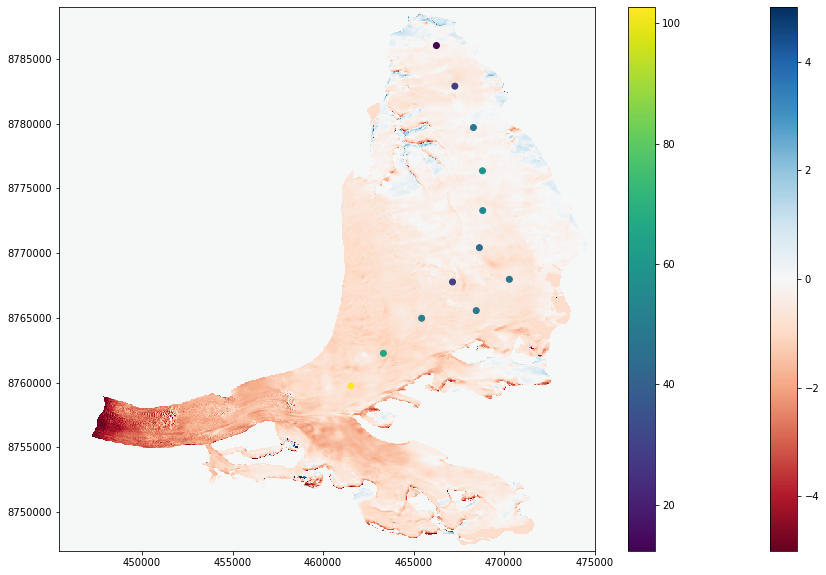

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
field = ax.pcolor(x_50m,y_50m, dhdt_50m_0914, cmap='RdBu', vmax=5, vmin=-5)
points = plt.scatter(vel_x, vel_y, c=vel_0914)
fig.colorbar(field, ax=ax)
fig.colorbar(points, ax = ax)

In [10]:
### adjust resolution ###
from scipy.ndimage import zoom

data_res = 50
res = 250
resample = data_res/res

Z_09 = zoom(Z_50m_09, resample)
Z_14 = zoom(Z_50m_14, resample)
Z_mean = zoom(Z_50m_mean, resample)
dhdt_0914 = zoom(dhdt_50m_0914, resample)
smb_fit = zoom(smb_50m_fit, resample)
NPI_DEM = zoom(NPI_50m_DEM, resample)
R2_Vel = zoom(R2_50m_Vel, resample)
R2_Vx = zoom(R2_50m_Vy, resample)
R2_Vy = zoom(R2_50m_Vy, resample)

mask = np.around(zoom(mask_50m, resample), 0)

x = zoom(x_50m, resample)
y = zoom(y_50m, resample)

In [11]:
### filter outliers in dhdt ###
dhdt_0914_new = np.zeros_like(dhdt_0914)
for i in range(np.shape(dhdt_0914)[0]):
    for j in range(np.shape(dhdt_0914)[1]):
        if mask[i, j]==0:
                dhdt_0914_new[i, j] = 0
        else:
            y_f, x_f = np.ogrid[:np.shape(dhdt_0914)[0], :np.shape(dhdt_0914)[1]]
            circle = (y_f - i) ** 2 + (x_f - j) ** 2 <= 20
            local_med = np.median(dhdt_0914[np.logical_and(circle, mask==1)])
            local_std = np.std(dhdt_0914[np.logical_and(circle, mask==1)])
            if dhdt_0914[i,j] >  local_med + 1* local_std:
                dhdt_0914_new[i, j]= local_med + 1* local_std
            elif dhdt_0914[i,j] < local_med - 1* local_std:
                dhdt_0914_new[i, j]= local_med - 1* local_std              
            else:
                dhdt_0914_new[i,j] = dhdt_0914[i,j]
#   
#bw = 1
#k = np.ones((bw, bw))
#buffer = ndimage.convolve(mask, k)/(bw)**2 
#criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)
#dhdt_0914_new[criterion] = np.nan
#dhdt_0914_new = inpaint_nans(dhdt_0914_new)

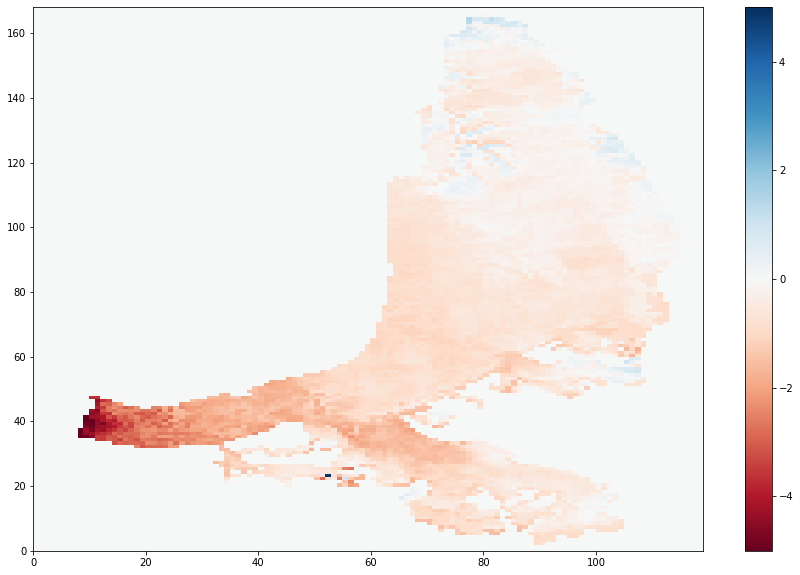

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
field = ax.pcolor(dhdt_0914_new, cmap='RdBu', vmax=5, vmin=-5)
#outline.plot(ax=ax)
fig.colorbar(field, ax=ax)

In [13]:
### ice temperature ###
ice_temp = 273
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))
print(A)

3.9565534675428266e-24


In [14]:
filename = "kronebreen_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {"ocean.always_grounded": "yes",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.8,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [15]:
WRIT_FILE = 'kronebreen_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 900.0             # [kg m-3]

ny, nx = np.shape(Z_09)
Lx = nx * res  # in m
Ly =  ny * res # in m

x_in = np.linspace(-Lx/2, Lx/2, nx)
y_in = np.linspace(-Ly/2, Ly/2, ny)

B_rec = Z_mean
B_init = copy.deepcopy(B_rec)
ice_surface_temp = np.ones((ny, nx))*ice_temp
#M_refs = np.nan_to_num(M_refs)
#M_refs *= mask

h_rec = Z_mean - B_rec

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y_in],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x_in],
        'thk':  ['m',
                 'ice thickness',
                 'land_ice_thickness',
                 1.0,
                 h_rec],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 B_rec],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             273,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0,
                                  smb_fit * ice_density * mask]
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  kronebreen_initialSetup.nc  created



In [16]:
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = (ds[var][time][:]).data
    return var_data

def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))
from scipy.interpolate import griddata

def shift(data, u, v, dx):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
    x_shift = x_shift+(u/uv_mag)*dx
    y_shift = y_shift+(v/uv_mag)*dx

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten()), method='linear').reshape(np.shape(u))
    return newgrid

def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

def get_nearest(x_ref,y_ref,reference, x_dat, y_dat):
    grid_temp = []
    for i in range(len(x_dat)):
        abslat = np.abs(x_ref-x_dat[i])
        abslon= np.abs(y_ref-y_dat[i])

        c = np.maximum(abslon,abslat)
        latlon_idx = np.argmin(c)
        grid_temp.append(reference.flat[latlon_idx])
    return grid_temp

In [17]:
def create_script(forward_or_iteration, nx, ny):
    print("""#!/bin/bash
    ###### run script for experiment synthetic1 ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx {} -My {} -Mz 50 -Mbz 1 -Lz 1500 -Lbz 1"'.format(nx, ny))
    print('PHYS="-stress_balance ssa+sia -sia_flow_law isothermal_glen -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    #print('OCEAN="-dry"')
    print('CONF="-config_override kronebreen_conf.nc"')

    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.25 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 5e6"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# initialize Kronebreen"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag,enthalpybase,bwat"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')
    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $CONF $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [18]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('kronebreen_initialize.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward', nx, ny)
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()
    
!chmod +x kronebreen_initialize.sh
!./kronebreen_initialize.sh 4 kronebreen_initialSetup.nc 1 kronebreen_output.nc > kronebreen_output_log.txt

Tau: 1.4235156377028002
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
dH: 1.5009078369140625


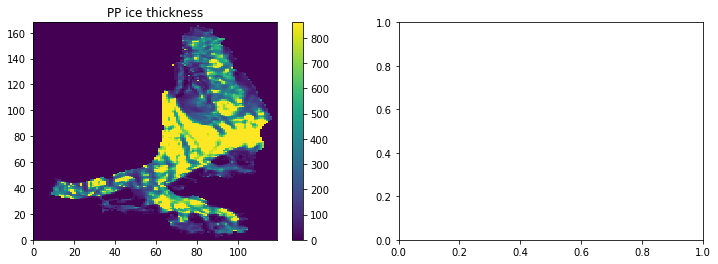

In [19]:
import richdem as rd
import math

dH = (np.nanmax(Z_mean[mask==1])-np.nanmin(Z_mean[mask==1]))/1000 #in km

tau = 0.005+1.598*dH-0.435*dH**2  #Haeberli and Hoelzle
print('Tau: {}'.format(tau))

slope = rd.TerrainAttribute(rd.rdarray(Z_mean, no_data=-9999), attrib='slope_riserun')/res
slope[slope<0.015] = 0.015
tan_slope = np.arctan(slope)
sin_slope = np.sin(tan_slope)
H=((tau*.8)*1e5)/(sin_slope*9.8*ice_density)

fig, ax = plt.subplots(1,2, figsize=(12,4))
field = ax[0].pcolor(H*mask)
fig.colorbar(field, ax = ax[0])
print('dH: {}'.format(dH))
ax[0].set_title('PP ice thickness')

def smooth_stress_coupling(H, field, mask, scl, max_scl, min_scl):
    field_new = np.zeros_like(field)
    for i in range(nx):
        for j in range(ny):
            if mask[j,i]==0:
                field_new[j,i] = field[j,i]
            else:
                x, y = np.ogrid[:np.shape(H)[0], :np.shape(H)[1]]
                coupling_length = scl*(H[j,i]/res)**2
                circle = (y - i) ** 2 + (x - j) ** 2 <= (min(max(coupling_length, min_scl),max_scl)/2)**2
                field_new[j,i]= np.mean(field[np.logical_and(circle, mask==1)])
    return field_new
         

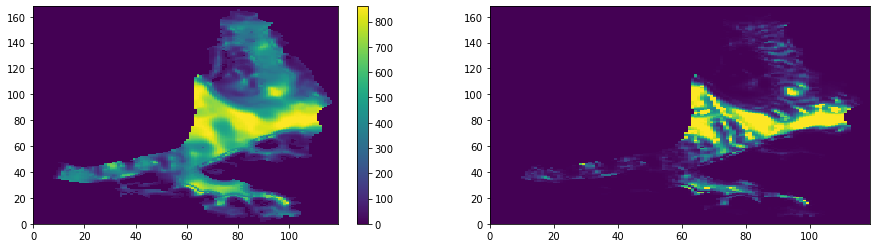

In [20]:
H_smooth = copy.deepcopy(H)
sin_slope_smooth = copy.deepcopy(sin_slope)
for i in range(20):
    sin_slope_smooth = smooth_stress_coupling(H_smooth, sin_slope, mask, 4, 8,2)
    H_smooth =(tau*.8)*1e5/(sin_slope_smooth*9.81*ice_density)

fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(H_smooth*mask)
fig.colorbar(field, ax=ax[0])
T=(2*A*(9.8*ice_density)**3)/5
D=mask*T*H_smooth**5*(slope)**2
field2 = ax[1].pcolor(D, vmax = 1e-1)

In [21]:
### bed recovery ###
S_rec = copy.deepcopy(Z_mean)
S_rec[mask==0]=np.nan
S_rec = gauss_filter(S_rec, .7, 3)
S_rec[mask==0]=Z_mean[mask==0]

H_smooth_D = copy.deepcopy(H_smooth)
H_smooth_D[D>1e-1] = (1e-1/(T*(slope[D>1e-1])**2))**(1/5)

B_rec = copy.deepcopy(S_rec)
B_rec[mask==1] = np.maximum(S_rec[mask==1]-1000, S_rec[mask==1]-H_smooth_D[mask==1])
B_rec[mask==0] = np.nan
B_rec = gauss_filter(B_rec, .6, 3)
B_rec[np.logical_or(B_rec > S_rec, mask==0)]=S_rec[np.logical_or(B_rec > S_rec, mask==0)]
#B_rec[B_rec>S_rec] = S_rec[B_rec>S_rec]
B_init = copy.deepcopy(B_rec)
N = 900*9.8*(Z_mean - B_init) - 1000*9.8*abs(B_init)

dh_ref = copy.deepcopy(dhdt_0914_new)

B_rec_all = []
dh_all = []
misfit_all = []
B_misfit_vs_iter=[]
dh_misfit_vs_iter=[]
S_rec_all = []
vel_all = []

pmax = 500
dt = .1
beta = .5
bw = 2

!cp kronebreen_output.nc kronebreen_iteration_out.nc
    
original_stdout = sys.stdout
with open('kronebreen_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x kronebreen_iteration_script.sh

<ipython-input-16-c61cd7aec4f4>:39: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


In [61]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_rec - B_rec
        
    !cp kronebreen_iteration_out.nc kronebreen_iteration_in.nc
    nc_updated = NC('kronebreen_iteration_in.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated['tauc'][0,:,:]= (500+B_init)*3e3
    nc_updated.close()
    
    cmd = ["./kronebreen_iteration_script.sh", '6', 'kronebreen_iteration_in.nc', str(dt), 'kronebreen_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('kronebreen_iteration_log.txt', 'a'))
    
    h_rec = get_nc_data('kronebreen_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    mask_iter = get_nc_data('kronebreen_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    #criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)
    #vel = np.maximum(0, get_nc_data('kronebreen_iteration_out.nc', 'velbar_mag', 0).data)
    #diff = get_nc_data('kronebreen_iteration_out.nc', 'diffusivity', 0)
    
    u = get_nc_data('kronebreen_iteration_out.nc', 'uvelsurf', 0)
    #u[criterion] = 0
    v = get_nc_data('kronebreen_iteration_out.nc', 'vvelsurf', 0)
    #v[criterion] = 0
    criterion = np.where(np.logical_and(mask_iter+shift(mask_iter, u, v, 1)>1, mask_iter+shift(mask_iter, u, v, 1)<2)) 

    misfit = shift((dh_rec-dh_ref), u, v, 0.3)*mask
    #misfit = (dh_rec - dh_ref)*mask
    #misfit/= (1+diff*1000)   ### adjust misfit for velocity to stabilize reconstruction
    #misfit /= (10 + diff**1.01 / (np.median(diff[mask==1]**1.01)+1e-5))

    B_rec = B_rec - beta * (misfit)
    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.05) * misfit[np.logical_and(mask==1, h_rec>20)] 
    
    ''''
    narrow = copy(mask)  ### identify grid points where the glacier is narrow and which should be spared from smoothing
    for i in range(nx):
        for j in range(ny):
            if mask[j,i]==0:
                narrow[j,i] = 0
            else:
                xn, yn = np.ogrid[:np.shape(S_ref)[0], :np.shape(S_ref)[1]]
                circle = (yn - i) ** 2 + (xn - j) ** 2 <= 2**2
                narrow[j,i] = np.sum(mask[circle]) < 12
                    
    B_rec_narrow = copy(B_rec)
    '''
    slope_iter = rd.TerrainAttribute(rd.rdarray(S_rec, no_data=-9999), attrib='slope_riserun')/res
    
    H_rec = S_rec - B_rec
    D_iter = mask*T*H_rec**5*(slope_iter)**2
    H_rec[D_iter>1e-1] = (1e-1/(T*(slope_iter[D_iter>1e-1])**2))**(1/5)
    #H_rec[mask==0] = np.nan
    #H_smooth = gauss_filter(H_rec, .5, truncate=3)
    #H_rec += np.minimum(abs(misfit), abs(H_smooth-H_rec))*np.sign(H_smooth-H_rec)
    #H_rec[np.isnan(H_rec)] = 0
    B_rec = S_rec - H_rec

    #H_smooth = ndimage.gaussian_filter(H_rec, (500/res)/7, truncate=3)
    #H_rec += np.minimum(abs(misfit), abs(H_smooth-H_rec))*np.sign(H_smooth-H_rec)
    #B_rec[np.logical_and(narrow, vel>10)] = B_rec_narrow[np.logical_and(narrow, vel>10)]
    
    ### buffer ###
    
#    h_inpaint = S_rec-B_rec
#    h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
#    #h_inpaint[:,:90] = S_rec[:,:90]-B_rec[:,:90]
#    h_inpaint = inpaint_nans(h_inpaint)
#    B_rec = S_rec - h_inpaint
    
    ### buffer end ###
    
    #B_rec[np.logical_and(narrow, vel>10)] = B_rec_narrow[np.logical_and(narrow, vel>10)]

    #B_rec[mask==1]=np.minimum(S_ref[mask==1]-50, B_rec[mask==1])
    B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
    B_rec[B_rec>Z_mean]=Z_mean[B_rec>Z_mean]
    S_rec[mask == 0]= Z_mean[mask == 0]
    B_rec[mask == 0]= Z_mean[mask == 0]
    
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    misfit[mask==0] = np.nan
    misfit_all.append(misfit)
    S_rec_all.append(S_rec)
    #vel_all.append(vel)
    
    B_misfit_vs_iter.append(np.mean(abs(B_rec-B_init)))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))

  0%|          | 1/500 [00:05<46:33,  5.60s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  0%|          | 2/500 [00:13<56:52,  6.85s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  1%|          | 3/500 [00:21<59:56,  7.24s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  1%|          | 4/500 [00:28<59:37,  7.21s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  1%|          | 5/500 [00:38<1:08:39,  8.32s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  1%|          | 6/500 [00:47<1:11:45,  8.72s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  1%|▏         | 7/500 [00:56<1:12:25,  8.82s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  2%|▏         | 8/500 [01:09<1:22:57, 10.12s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  2%|▏         | 9/500 [01:20<1:23:58, 10.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  2%|▏         | 10/500 [01:29<1:20:43,  9.88s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  2%|▏         | 11/500 [01:37<1:16:29,  9.38s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  2%|▏         | 12/500 [01:46<1:14:42,  9.19s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  3%|▎         | 13/500 [01:54<1:10:26,  8.68s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  3%|▎         | 14/500 [02:07<1:21:21, 10.04s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  3%|▎         | 15/500 [02:15<1:17:22,  9.57s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  3%|▎         | 16/500 [02:29<1:27:55, 10.90s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  3%|▎         | 17/500 [02:38<1:21:43, 10.15s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  4%|▎         | 18/500 [02:48<1:21:31, 10.15s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  4%|▍         | 19/500 [02:58<1:21:29, 10.17s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  4%|▍         | 20/500 [03:06<1:15:56,  9.49s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  4%|▍         | 21/500 [03:15<1:14:22,  9.32s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  4%|▍         | 22/500 [03:25<1:17:37,  9.74s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  5%|▍         | 23/500 [03:35<1:16:28,  9.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  5%|▍         | 24/500 [03:43<1:13:22,  9.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  5%|▌         | 25/500 [03:51<1:09:37,  8.79s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  5%|▌         | 26/500 [03:58<1:04:23,  8.15s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  5%|▌         | 27/500 [04:04<1:00:47,  7.71s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  6%|▌         | 28/500 [04:11<59:29,  7.56s/it]  

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  6%|▌         | 29/500 [04:18<56:48,  7.24s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  6%|▌         | 30/500 [04:25<55:49,  7.13s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  6%|▌         | 31/500 [04:31<54:22,  6.96s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  6%|▋         | 32/500 [04:38<54:02,  6.93s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  7%|▋         | 33/500 [04:47<57:49,  7.43s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  7%|▋         | 34/500 [04:56<1:02:01,  7.99s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  7%|▋         | 35/500 [05:04<1:01:38,  7.95s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  7%|▋         | 36/500 [05:12<1:01:16,  7.92s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  7%|▋         | 37/500 [05:20<1:01:29,  7.97s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  8%|▊         | 38/500 [05:28<1:01:47,  8.02s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  8%|▊         | 39/500 [05:37<1:04:00,  8.33s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  8%|▊         | 40/500 [05:46<1:06:03,  8.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  8%|▊         | 41/500 [05:56<1:08:03,  8.90s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  8%|▊         | 42/500 [06:06<1:10:52,  9.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  9%|▊         | 43/500 [06:14<1:08:24,  8.98s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  9%|▉         | 44/500 [06:23<1:07:35,  8.89s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  9%|▉         | 45/500 [06:32<1:08:26,  9.03s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  9%|▉         | 46/500 [06:42<1:08:52,  9.10s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  9%|▉         | 47/500 [06:50<1:07:40,  8.96s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 10%|▉         | 48/500 [07:01<1:10:10,  9.32s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 10%|▉         | 49/500 [07:09<1:07:57,  9.04s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 10%|█         | 50/500 [07:18<1:08:39,  9.16s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 10%|█         | 51/500 [07:29<1:11:10,  9.51s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 10%|█         | 52/500 [07:38<1:10:53,  9.49s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 11%|█         | 53/500 [07:46<1:07:56,  9.12s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 11%|█         | 54/500 [07:55<1:05:42,  8.84s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 11%|█         | 55/500 [08:04<1:05:58,  8.90s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 11%|█         | 56/500 [08:11<1:02:12,  8.41s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 11%|█▏        | 57/500 [08:20<1:04:32,  8.74s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 12%|█▏        | 58/500 [08:28<1:02:48,  8.53s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 12%|█▏        | 59/500 [08:37<1:03:36,  8.65s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 12%|█▏        | 60/500 [08:44<59:58,  8.18s/it]  

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 12%|█▏        | 61/500 [08:52<58:07,  7.94s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 12%|█▏        | 62/500 [08:58<54:36,  7.48s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 13%|█▎        | 63/500 [09:04<51:36,  7.09s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 13%|█▎        | 64/500 [09:11<50:13,  6.91s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 13%|█▎        | 65/500 [09:17<48:53,  6.74s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 13%|█▎        | 66/500 [09:24<48:53,  6.76s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 13%|█▎        | 67/500 [09:30<46:58,  6.51s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 14%|█▎        | 68/500 [09:38<49:47,  6.92s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 14%|█▍        | 69/500 [09:45<50:41,  7.06s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 14%|█▍        | 70/500 [09:54<53:12,  7.42s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 14%|█▍        | 71/500 [10:00<50:15,  7.03s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 14%|█▍        | 72/500 [10:08<51:58,  7.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 15%|█▍        | 73/500 [10:14<50:13,  7.06s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 15%|█▍        | 74/500 [10:21<49:40,  7.00s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 15%|█▌        | 75/500 [10:28<50:10,  7.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 15%|█▌        | 76/500 [10:35<50:17,  7.12s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 15%|█▌        | 77/500 [10:43<50:57,  7.23s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 16%|█▌        | 78/500 [10:50<50:12,  7.14s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 16%|█▌        | 79/500 [10:56<48:37,  6.93s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 16%|█▌        | 80/500 [11:03<47:43,  6.82s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 16%|█▌        | 81/500 [11:09<45:19,  6.49s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 16%|█▋        | 82/500 [11:15<45:39,  6.55s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 17%|█▋        | 83/500 [11:23<47:41,  6.86s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 17%|█▋        | 84/500 [11:30<47:20,  6.83s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 17%|█▋        | 85/500 [11:37<48:27,  7.01s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 17%|█▋        | 86/500 [11:44<49:18,  7.15s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 17%|█▋        | 87/500 [11:52<49:19,  7.17s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 18%|█▊        | 88/500 [11:58<48:12,  7.02s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 18%|█▊        | 89/500 [12:05<47:14,  6.90s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 18%|█▊        | 90/500 [12:11<45:56,  6.72s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 18%|█▊        | 91/500 [12:17<43:59,  6.45s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 18%|█▊        | 92/500 [12:24<44:44,  6.58s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 19%|█▊        | 93/500 [12:30<44:07,  6.51s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 19%|█▉        | 94/500 [12:37<43:48,  6.48s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 19%|█▉        | 95/500 [12:42<42:03,  6.23s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 19%|█▉        | 96/500 [12:49<43:04,  6.40s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 19%|█▉        | 97/500 [12:57<45:19,  6.75s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 20%|█▉        | 98/500 [13:03<44:58,  6.71s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 20%|█▉        | 99/500 [13:10<43:47,  6.55s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 20%|██        | 100/500 [13:18<47:13,  7.08s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 20%|██        | 101/500 [13:24<45:03,  6.78s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 20%|██        | 102/500 [13:31<45:45,  6.90s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 21%|██        | 103/500 [13:37<44:00,  6.65s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 21%|██        | 104/500 [13:45<47:06,  7.14s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 21%|██        | 105/500 [13:52<46:00,  6.99s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 21%|██        | 106/500 [13:59<45:34,  6.94s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 21%|██▏       | 107/500 [14:05<44:01,  6.72s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 22%|██▏       | 108/500 [14:12<45:05,  6.90s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 22%|██▏       | 109/500 [14:20<46:26,  7.13s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 22%|██▏       | 110/500 [14:28<47:26,  7.30s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 22%|██▏       | 111/500 [14:35<47:29,  7.33s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 22%|██▏       | 112/500 [14:43<48:26,  7.49s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 23%|██▎       | 113/500 [14:50<46:52,  7.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 23%|██▎       | 114/500 [14:57<45:50,  7.13s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 23%|██▎       | 115/500 [15:04<46:19,  7.22s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 23%|██▎       | 116/500 [15:12<48:18,  7.55s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 23%|██▎       | 117/500 [15:19<46:50,  7.34s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 24%|██▎       | 118/500 [15:27<47:46,  7.50s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 24%|██▍       | 119/500 [15:34<47:25,  7.47s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 24%|██▍       | 120/500 [15:43<48:35,  7.67s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 24%|██▍       | 121/500 [15:49<46:35,  7.38s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 24%|██▍       | 122/500 [15:56<44:51,  7.12s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 25%|██▍       | 123/500 [16:03<44:55,  7.15s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 25%|██▍       | 124/500 [16:11<45:29,  7.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 25%|██▌       | 125/500 [16:18<45:01,  7.20s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 25%|██▌       | 126/500 [16:24<43:39,  7.00s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 25%|██▌       | 127/500 [16:30<41:13,  6.63s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 26%|██▌       | 128/500 [16:37<41:27,  6.69s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 26%|██▌       | 129/500 [16:43<40:29,  6.55s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 26%|██▌       | 130/500 [16:51<43:18,  7.02s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 26%|██▌       | 131/500 [16:59<44:03,  7.16s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 26%|██▋       | 132/500 [17:05<42:20,  6.90s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 27%|██▋       | 133/500 [17:11<40:24,  6.61s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 27%|██▋       | 134/500 [17:18<40:58,  6.72s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 27%|██▋       | 135/500 [17:25<42:27,  6.98s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 27%|██▋       | 136/500 [17:32<41:33,  6.85s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 27%|██▋       | 137/500 [17:38<39:49,  6.58s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 28%|██▊       | 138/500 [17:44<39:31,  6.55s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 28%|██▊       | 139/500 [17:50<38:21,  6.38s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 28%|██▊       | 140/500 [17:57<38:17,  6.38s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 28%|██▊       | 141/500 [18:04<39:05,  6.53s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 28%|██▊       | 142/500 [18:10<39:16,  6.58s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 29%|██▊       | 143/500 [18:17<39:23,  6.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 29%|██▉       | 144/500 [18:24<40:09,  6.77s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 29%|██▉       | 145/500 [18:30<38:24,  6.49s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 29%|██▉       | 146/500 [18:37<38:36,  6.54s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 29%|██▉       | 147/500 [18:43<38:39,  6.57s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 30%|██▉       | 148/500 [18:49<37:52,  6.46s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 30%|██▉       | 149/500 [18:57<38:52,  6.64s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 30%|███       | 150/500 [19:03<38:52,  6.67s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 30%|███       | 151/500 [19:10<38:53,  6.69s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 30%|███       | 152/500 [19:16<37:30,  6.47s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 31%|███       | 153/500 [19:24<40:06,  6.94s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 31%|███       | 153/500 [19:33<44:20,  7.67s/it]


KeyboardInterrupt: 

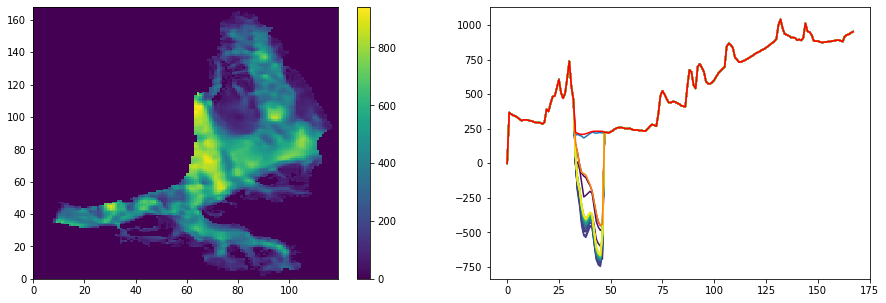

In [81]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(S_rec - B_rec)#, vmin=-500, vmax=500, cmap='RdBu')
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),20):
    lines = axes[1].plot(range(ny), B_rec_all[i][:,30], color=colors[i])
lines2 = axes[1].plot(range(ny), Z_mean[:,30])
lines2 = axes[1].plot(range(ny), B_init[:,30])
lines2 = axes[1].plot(range(ny), S_rec[:,30], color='r')

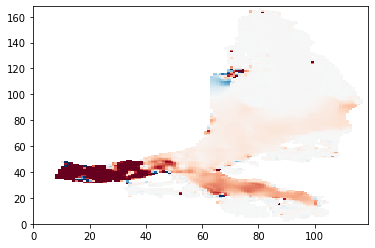

In [60]:
plt.pcolor(misfit_all[-1], cmap='RdBu', vmin=-1, vmax=1)

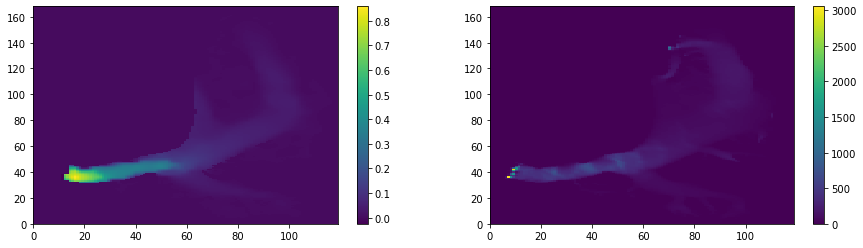

In [52]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(R2_Vel*mask)
field1 = ax[1].pcolor(np.maximum(0,get_nc_data('kronebreen_iteration_out.nc', 'velsurf_mag', 0)))
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

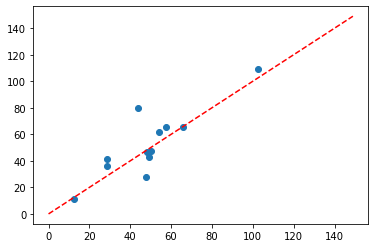

In [63]:
fig, ax = plt.subplots()
points = ax.scatter(vel_0914, get_nearest(x,y,get_nc_data('kronebreen_iteration_out.nc', 'velsurf_mag', 0), vel_x, vel_y))
line = ax.plot(range(150), range(150), '--',c='r')

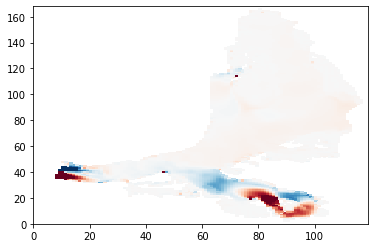

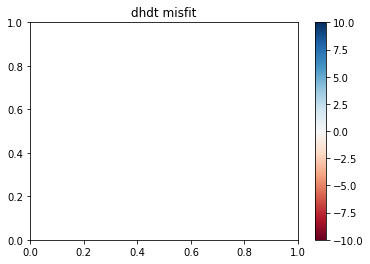

In [44]:
from IPython.display import display, clear_output #needed for animated plots

fig, axes = plt.subplots()
for i in range(0,len(B_rec_all),10):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-10, vmax=10)
    #field = axes.pcolor(S_rec_all[i]-B_rec_all[i], vmax=800, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

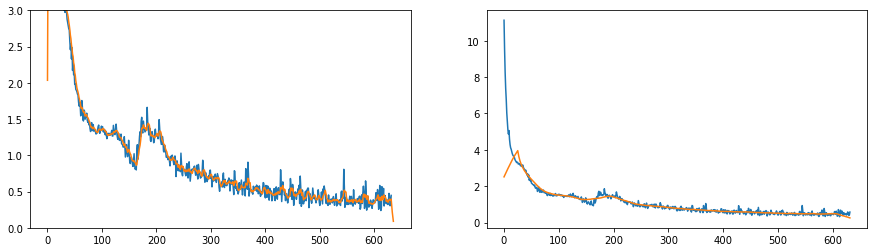

In [64]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
line = ax[0].plot(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)))
line = ax[0].plot(np.convolve(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)), np.ones(5)/5))
ax[0].set_ylim([0,3])
line2 = ax[1].plot(dh_misfit_vs_iter)
line1 = ax[1].plot(np.convolve(dh_misfit_vs_iter, np.ones(50)/50, mode='same'))

In [65]:
#Z_at_rad = get_nearest(x[mask==1],y[mask==1],Z_mean[mask==1], x_rad, y_rad)
#thick_ref_at_rad = Z_at_rad - rad[:,0]
#thick_rec = S_rec - B_rec
#thick_rec_at_rad = get_nearest(x[mask==1], y[mask==1], thick_rec[mask==1], x_rad, y_rad)

In [71]:
Z_at_rad = get_nearest(x[mask==1],y[mask==1],NPI_DEM[mask==1], x_rad, y_rad)
df = pd.DataFrame({"Z":Z_at_rad,"rad":rad[:,0], "x_rad":x_rad[:,0], "y_rad": y_rad[:,0]})
df = df.groupby('Z').mean()
thick_ref_at_rad = df.index - df['rad']
thick_rec = S_rec - B_rec
thick_rec_at_rad = get_nearest(x[mask==1], y[mask==1], thick_rec[mask==1], np.array(df['x_rad']), np.array(df['y_rad']))

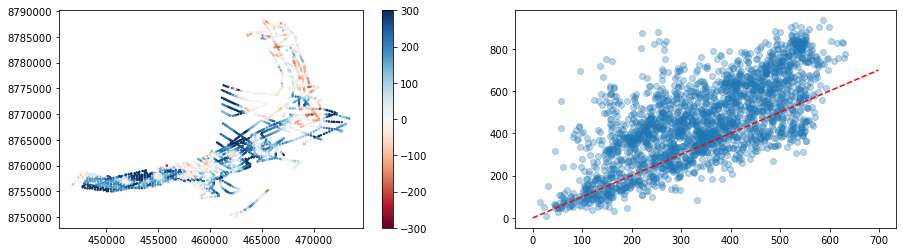

In [74]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].scatter(np.array(df['x_rad']), np.array(df['y_rad']), c=(thick_rec_at_rad - thick_ref_at_rad), cmap='RdBu', s=2, vmin=-300, vmax=300)
fig.colorbar(field, ax = ax[0])

scatter = ax[1].scatter(thick_ref_at_rad, thick_rec_at_rad, marker='o', alpha=.3)
line = ax[1].plot(range(700), range(700), '--', c='r')

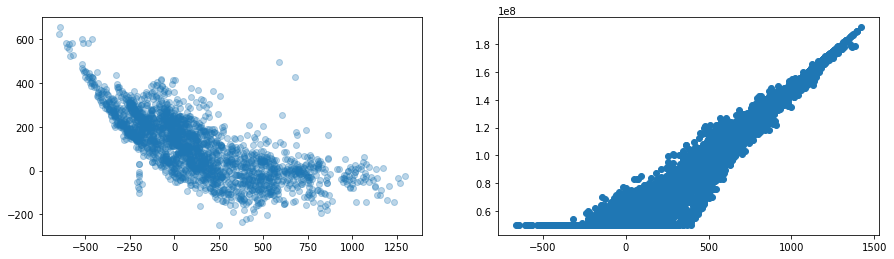

In [75]:
#data_at_rad = get_nearest(x,y,get_nc_data('kronebreen_iteration_out.nc', 'thk', 0), np.array(df['x_rad']), np.array(df['y_rad']))
data_at_rad = get_nearest(x,y, B_rec, np.array(df['x_rad']), np.array(df['y_rad']))
fig, ax = plt.subplots(1,2, figsize=(15,4))
points = ax[0].scatter(data_at_rad, (thick_rec_at_rad - thick_ref_at_rad), alpha=.3)
points1 = ax[1].scatter(B_rec, (500+np.maximum(0, B_init))*1e5)

In [78]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thick_rec_at_rad - thick_ref_at_rad)#/np.mean(thick_ref_at_rad)
mean_dev = np.nanmean((dev))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
print('mean deviation: {}'.format(mean_dev))
print('median deviation: {}'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

mean deviation: 109.99316743564735
median deviation: 108.8193760685756
Interquartile range of deviation: 205.94049618839654
95% confidence intervall: [ 5.74460491 -5.74460491]


In [ ]:
import gdal

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def write_geotiff(array, geoinfo):
    dst_filename = '{}.tiff'.format(namestr(array, globals())[0])
    y_pixels, x_pixels = np.shape(array)  # number of pixels in x

    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
    dataset.GetRasterBand(1).WriteArray(np.flip(array, axis=0))

    # follow code is adding GeoTranform and Projection
    #geotrans=geoinfo.GetGeoTransform()  #get GeoTranform from existed 'data0'
    #proj=geoinfo.GetProjection() #you can get from a exsited tif or import 
    #dataset.SetGeoTransform(geotrans)
    #dataset.SetProjection(proj)
    #dataset.FlushCache()
    

In [ ]:
write_geotiff(Z_mean, 1)

In [ ]:
blo_org = np.zeros((9,9))
blo_org[4,4] = 1
#blo[5,4] = 1
blo = ndimage.gaussian_filter(blo_org, .7, truncate=3)
fig, ax = plt.subplots()
field = ax.pcolor(blo_org - blo)
fig.colorbar(field, ax = ax)
#print(np.max(blo-ndimage.gaussian_filter(blo, .3, 4)))

In [53]:
    ## save output    
    import shelve
    bk = shelve.open('./it500_beta.5_dt.1_taucconst5e7_q.6','n')
    for k in dir():
        if k in ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

bk was not saved
copy was not saved
exit was not saved
f was not saved
get_ipython was not saved
getopt was not saved
gpd was not saved
math was not saved
nc was not saved
nc_updated was not saved
ndimage was not saved
np was not saved
optimize was not saved
original_stdout was not saved
pd was not saved
plt was not saved
quit was not saved
rasterio was not saved
rd was not saved
scipy was not saved
shelve was not saved
spatial was not saved
st was not saved
subprocess was not saved
sys was not saved
tqdm was not saved
var was not saved
